# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<a id='intro'></a>

# Содержание


[Подготовка данных](#chapter1)

[Обучение моделей](#chapter2)

[Анализ моделей](#chapter3)

[Вывод](#chapter4)


<a id='chapter1'></a>

# Подготовка данных


Загрузим переданный файл с данными и посмотрим информацию по нему.


In [1]:
#загрузка необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
#загрузка файла с данными и просмотр первых пяти строк таблицы
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
#просмотр информации о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB



В таблице содержится следующая информация:

* <i> DateCrawled </i> - дата скачивания анкеты из базы

* <i> VehicleType </i> - тип автомобильного кузова

* <i> RegistrationYear </i> - год регистрации автомобиля

* <i> Gearbox </i> - тип коробки передач

* <i> Power </i> - мощность (л.с.)

* <i> Model </i> - модель автомобиля

* <i> Kilometer </i> - пробег (км)

* <i> RegistrationMonth </i> - месяц регистрации автомобиля

* <i> FuelType </i> - тип топлива

* <i> Brand </i> - марка автомобиля

* <i> NotRepaired </i> - была машина в ремонте или нет

* <i> DateCreated </i> - дата создания анкеты

* <i> NumberOfPictures </i> - количество фотографий автомобиля

* <i> PostalCode </i> - почтовый индекс владельца анкеты

* <i> LastSeen </i> - дата последней активности пользователя

* <i> Price </i> - цена



Для решения поставленной задачи - предсказание рыночной стоимости автомобиля - нам не нужны все эти столбцы. Например, год регистрации автомобиля имеет значения, а вот месяц - нет. Также вряд ли на стоимость может повлиять почтовый индекс владельца анкеты или, например, дата создания анкеты.


In [4]:
#удалим ненужные для задачи столбцы
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen'], axis=1).reset_index(drop=True)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,NumberOfPictures
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,0
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,0
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,0
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,0
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,0



Проверим данные на наличие дублирующихся строк.


In [5]:
data.duplicated().sum()

45040


Видим, что присутствуют повторяющиеся строки, удалим их.


In [6]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0


Видим, что в данных присутствуют пропуски.


In [7]:
data.isna().sum()

Price                   0
VehicleType         34559
RegistrationYear        0
Gearbox             17207
Power                   0
Model               18361
Kilometer               0
FuelType            30764
Brand                   0
NotRepaired         64558
NumberOfPictures        0
dtype: int64


В столбцах с типом кузова или модели есть вариант "other", мы можем пропуски в этих столбцах заменить на это значение. Но некоторые пропуски, например, была ли машина в ремонте или нет, мы не можем заполнить. Заполним пропуски новым значением <i> unknown </i>. В дальнейшем, при применении к ним техники прямого кодирования будет создан отдельный столбец с неопределенными значениями и модель будет по ним также обучаться.


In [8]:
data.loc[data['VehicleType'].isna(), 'VehicleType'] = 'unknown'
data.loc[data['Model'].isna(), 'Model'] = 'unknown'
data.loc[data['Gearbox'].isna(), 'Gearbox'] = 'unknown'
data.loc[data['FuelType'].isna(), 'FuelType'] = 'unknown'
data.loc[data['NotRepaired'].isna(), 'NotRepaired'] = 'unknown'


Теперь посмотрим описание численных столбцов.


In [9]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,NumberOfPictures
count,309329.000000,309329.000000,309329.000000,309329.000000,309329.0
mean,4486.937196,2004.360105,110.976908,127217.735809,0.0
std,4564.852796,92.541399,200.969473,38532.941010,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.0
25%,1100.000000,1999.000000,69.000000,125000.000000,0.0
50%,2800.000000,2003.000000,105.000000,150000.000000,0.0
75%,6500.000000,2008.000000,143.000000,150000.000000,0.0
max,20000.000000,9999.000000,20000.000000,150000.000000,0.0



Видим значения с нулевой ценой, с неправдоподобным годом регистрации и мощностью. Также видим, что для всех автомобилей столбец с количеством фотографии полностью нулевой, значит можем по нему не обучать модели.


In [10]:
data = data.loc[(data['Price'] > 0) & (data['RegistrationYear'] > 1870) & (data['RegistrationYear'] < 2016)]
data = data.loc[(data['Power'] > 0) & (data['Power'] < 1000)]
data = data.drop(['NumberOfPictures'], axis=1).reset_index(drop=True)


Теперь объявим признаки для обучения моделей и целевой признак.


In [11]:
target = data['Price']
features = data.drop(['Price'], axis=1).reset_index(drop=True)

[К оглавлению](#intro)

<a id='chapter2'></a>

# Обучение моделей


Подготовим данные перед обучением модели. Обучить модель на тех данных, что у нас есть, не получится: признаки могут быть только численные, а наши данные содержат и категориальные признаки. Преобразуем их в численные техникой прямого кодирования. Столбец с информацией о модели автомобиля  содержит очень много категорий, обработаем его с помощью Ordinal Encoder.


<a id='correct1'></a>

In [12]:
encoder = OrdinalEncoder()
encoder.fit(features)
features_new = pd.DataFrame(encoder.transform(features), columns=features.columns)
features.loc[:, 'Model'] = features_new.loc[:, 'Model']
print(features.head())

  VehicleType  RegistrationYear Gearbox  Power  Model  Kilometer  FuelType  \
0       coupe              2011  manual    190  227.0     125000  gasoline   
1         suv              2004    auto    163  117.0     125000  gasoline   
2       small              2001  manual     75  116.0     150000    petrol   
3       small              2008  manual     69  101.0      90000  gasoline   
4       sedan              1995  manual    102   11.0     150000    petrol   

        Brand NotRepaired  
0        audi         yes  
1        jeep     unknown  
2  volkswagen          no  
3       skoda          no  
4         bmw         yes  


[Добавила функцию - построение гистограммы](#correct2)

In [13]:
features = (
    pd.get_dummies(features, columns=['VehicleType', 'Gearbox', 
                                      'FuelType', 'Brand', 'NotRepaired'], drop_first=True)
)


Тестовой выборки для предсказывания значений у нас нет. Поэтому необходимо общий набор данных разделить на три части: обучающую выборку, валидационную и тестовую в соотношении 3:1:1.

На обучающей выборке мы обучим модель, на валидационной - проверочной - подберем параметры.


In [14]:
#выделим тестовую выборку
data_features, features_test, data_target, target_test = (
train_test_split(features, target, test_size=0.2, random_state=0)
)
#выделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = (
train_test_split(data_features, data_target, test_size=0.25, random_state=0)
)
print('Количество объектов в обучающей выборке:', len(features_train))
print('Количество объектов в валидационной выборке:', len(features_valid))
print('Количество объектов в тестовой выборке:', len(features_test))
#удаляем промежуточные переменные
del data_features, data_target

Количество объектов в обучающей выборке: 150888
Количество объектов в валидационной выборке: 50297
Количество объектов в тестовой выборке: 50297



Теперь, после разделения набора данных на три выборки, нам необходимо масштабировать признаки. Если в одном столбце значения и их разбросы больше, чем в другом, то алгоритм решит, что этот признак важнее, а это не так: все признаки важны. 


In [15]:
#численные признаки
numeric=['RegistrationYear', 'Power', 'Kilometer']
#масштабирование
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [16]:
features_train.head()

,RegistrationYear,Power,Model,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
224182,-0.243700,-1.160533,226.0,0.612113,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
227903,1.305359,0.319960,221.0,0.612113,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10218,-0.088794,0.374125,59.0,0.612113,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
148886,-0.243700,-0.438341,75.0,0.612113,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
39586,0.840641,-0.907766,45.0,-0.053720,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0



Обучим модели несколькими алгоритмами. В качестве метрики будем использовать RMSE, а, поскольку нам также важно время обучения моделей, подсчитаем его и при выборе оптимальной модели будем учитывать не только метрику, но и время.


Будем использовать алгоритмы:

* линейная регрессия

* дерево решений

* случайный лес

* градиентный бустинг


<a id='correct2'></a>

In [17]:
#создадим результирующую таблицу
final = (
    pd.DataFrame(index=['Линейная регрессия', 'Дерево решений', 'Случайный лес', 'Градиентный бустинг'],
                columns=['RMSE', 'Время обучения', 'Время прогноза'])
)

In [18]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    df = pd.DataFrame(data)
    df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=df['feature_importance'], y=df['feature_names'])
    plt.title(model_type)
    plt.xlabel('Важность признаков')
    plt.ylabel('Признаки')

## Среднее значение

In [19]:
%%time
#заполнение средним значением
predictions = pd.Series(target_train.mean(), index=target_valid.index)
#рассчитываем RMSE
result_const = (mean_squared_error(target_valid, predictions))**(0.5)
print('RMSE константной модели:', result_const)

RMSE константной модели: 4675.7291576081425
CPU times: user 2.47 ms, sys: 349 µs, total: 2.82 ms
Wall time: 2.25 ms


## Линейная регрессия

In [20]:
%%time
#создаем модель
model_linear = LinearRegression()
#обучаем ее
model_linear.fit(features_train, target_train)
#предсказываем результаты на валидационной выборке
predictions = model_linear.predict(features_valid)
#рассчитываем RMSE
result_linear = (mean_squared_error(target_valid, predictions))**(0.5)
print('RMSE линейной регрессии:', result_linear)

RMSE линейной регрессии: 2817.373754123059
CPU times: user 1.68 s, sys: 723 ms, total: 2.41 s
Wall time: 2.38 s


In [21]:
final.loc['Линейная регрессия', 'Время обучения'] = 2.5

## Дерево решений

In [22]:
def rmse(target, predict):
    return (mean_squared_error(target, predict))**(0.5)

In [23]:
%%time
#создаем модель
model_tree = DecisionTreeRegressor(random_state=0)
#подбираем лучшие гиперпараметры
parameters = {'max_depth': range(1, 11)}
grid_tree = GridSearchCV(model_tree, scoring=make_scorer(rmse, greater_is_better=False), param_grid=parameters, cv=5)
#обучаем ее
grid_tree.fit(features_train, target_train)
#предсказываем результаты на валидационной выборке
predictions = grid_tree.predict(features_valid)
#рассчитываем RMSE
result_tree = (mean_squared_error(target_valid, predictions))**(0.5)
print('RMSE дерева решений:', result_tree)

RMSE дерева решений: 2001.5405359892252
CPU times: user 26.8 s, sys: 745 ms, total: 27.6 s
Wall time: 27.7 s


<a id='correct3'></a>

In [24]:
final.loc['Дерево решений', 'RMSE'] = result_tree
final.loc['Дерево решений', 'Время обучения'] = 27.9

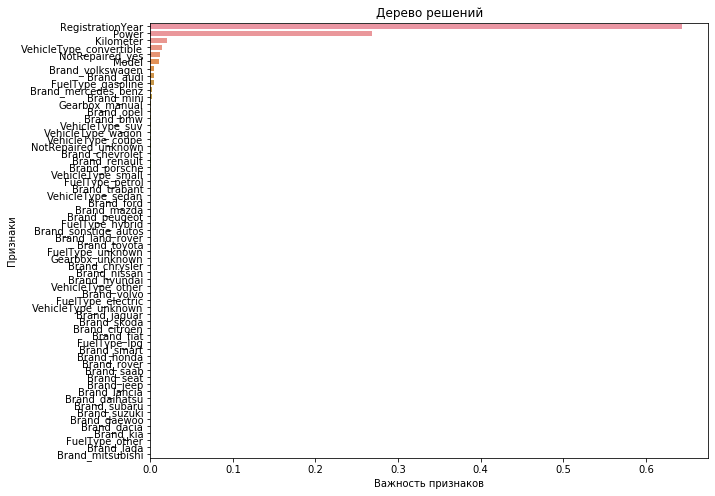

In [25]:
plot_feature_importance(grid_tree.best_estimator_.feature_importances_, features_train.columns, 'Дерево решений')

## Случайный лес

In [26]:
%%time
#задаем параметры, в которые сохраним наилучшие результаты
best_est_forest = 0
best_depth_forest = 0
best_result_forest = 10000000
model_forest = None
#в цикле перебираем значения гиперпараметров
for est in range(10, 51, 5):
    for depth in range(1, 11):
        #задаем модель с текущими гиперпараметрами
        model = RandomForestRegressor(random_state=0, n_estimators=est, max_depth=depth)
        #обучаем модель на обучающей выборке
        model.fit(features_train, target_train)
        #предсказываем результаты на валидационной выборке
        predictions = model.predict(features_valid)
        #рассчитываем RMSE
        result = (mean_squared_error(target_valid, predictions))**(0.5)
        #выбираем наилучший результат
        if result < best_result_forest:
            best_result_forest = result
            best_depth_forest = depth
            best_est_forest = est
            model_forest = model
print('RMSE случайного леса:', best_result_forest)

RMSE случайного леса: 1898.7607749326812
CPU times: user 17min 6s, sys: 2.07 s, total: 17min 8s
Wall time: 17min 14s


In [27]:
final.loc['Случайный лес', 'RMSE'] = best_result_forest
final.loc['Случайный лес', 'Время обучения'] = 1055

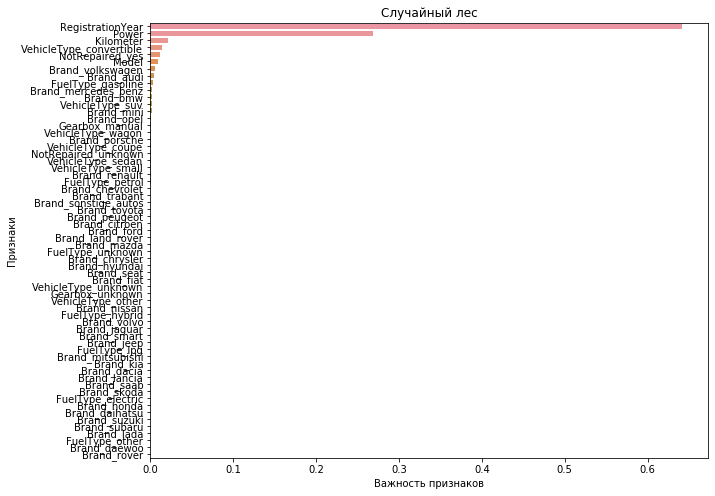

In [28]:
plot_feature_importance(model_forest.feature_importances_, features_train.columns, 'Случайный лес')

## Градиентный бустинг

In [29]:
%%time
#создаем модель
model_lgbm = LGBMRegressor()
#подбираем лучшие гиперпараметры
parameters = {'n_estimators': range(100, 500, 100), 'max_depth': range(1, 11)}
grid_lgbm = GridSearchCV(model_lgbm, scoring=make_scorer(rmse, greater_is_better=False), param_grid=parameters, cv=5)
#обучаем ее
grid_lgbm.fit(features_train, target_train)
#предсказываем результаты на валидационной выборке
predictions = grid_lgbm.predict(features_valid)
#рассчитываем RMSE
result_lgbm = (mean_squared_error(target_valid, predictions))**(0.5)
print('RMSE градиентного бустинга:', result_lgbm)

RMSE градиентного бустинга: 1624.8951666413807
CPU times: user 35min 27s, sys: 15.7 s, total: 35min 42s
Wall time: 36min 8s


In [30]:
final.loc['Градиентный бустинг', 'RMSE'] = result_lgbm
final.loc['Градиентный бустинг', 'Время обучения'] = 2169

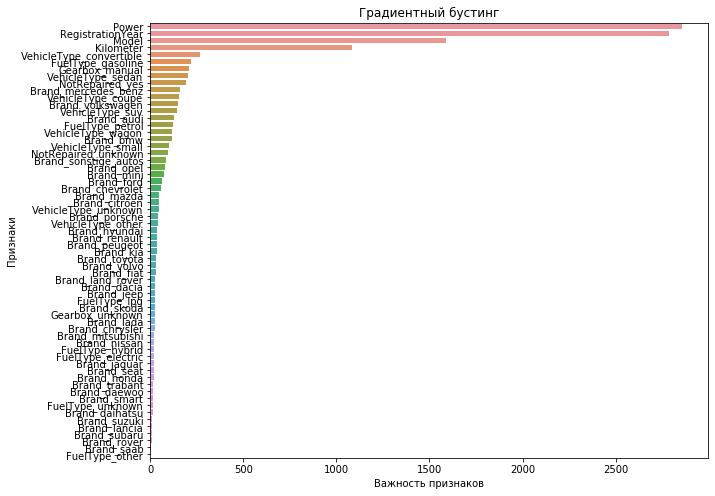

In [31]:
plot_feature_importance(grid_lgbm.best_estimator_.feature_importances_, features_train.columns, 'Градиентный бустинг')

[К оглавлению](#intro)

<a id='chapter3'></a>

# Анализ моделей


Итак, видим, что модель, созданная по алгоритму градиентного бустинга показывает не только лучший результат, но и время. Посмотрим, какие результаты метрики и времени покажут алгоритмы на тестовой выборке.


In [32]:
%%time
predictions = model_linear.predict(features_test)
result_linear = rmse(target_test, predictions)
print('RMSE линейной регрессии:', result_linear)

RMSE линейной регрессии: 2825.239391580224
CPU times: user 30.4 ms, sys: 116 µs, total: 30.6 ms
Wall time: 13.3 ms


In [33]:
final.loc['Линейная регрессия', 'Время прогноза'] = 0.013
final.loc['Линейная регрессия', 'RMSE'] = result_linear

In [34]:
%%time
predictions = grid_tree.predict(features_test)
result_tree = rmse(target_test, predictions)
print('RMSE дерева решений:', result_tree)

RMSE дерева решений: 2007.3933879041947
CPU times: user 18.4 ms, sys: 4.07 ms, total: 22.4 ms
Wall time: 21.8 ms


In [35]:
final.loc['Дерево решений', 'Время прогноза'] = 0.022
final.loc['Дерево решений', 'RMSE'] = result_tree

In [36]:
%%time
predictions = model_forest.predict(features_test)
result_forest = rmse(target_test, predictions)
print('RMSE случайного леса:', result_forest)

RMSE случайного леса: 1897.493494788774
CPU times: user 216 ms, sys: 0 ns, total: 216 ms
Wall time: 214 ms


In [37]:
final.loc['Случайный лес', 'Время прогноза'] = 0.214
final.loc['Случайный лес', 'RMSE'] = result_forest

In [38]:
%%time
predictions = grid_lgbm.predict(features_test)
result_lgbm = rmse(target_test, predictions)
print('RMSE градиентного бустинга:', result_lgbm)

RMSE градиентного бустинга: 1618.6405880336945
CPU times: user 2.6 s, sys: 3.24 ms, total: 2.61 s
Wall time: 2.55 s


In [39]:
final.loc['Градиентный бустинг', 'Время прогноза'] = 2.6
final.loc['Градиентный бустинг', 'RMSE'] = result_lgbm

[К оглавлению](#intro)

<a id='chapter4'></a>

# Вывод


В данной работе был проведен анализ обучаемости и скорости работы моделей для прогноза рыночной стоимости автомобилей. Было рассмотрено пять алгоритмов построения моделей:

* заполнение средним значением

* линейная регрессия

* дерево решений

* случайный лес

* градиентный бустинг

В моделях проводилось изменение гиперпараметров для получения наилучшего результата. Изменялись глубина дерева и количество деревьев. В рассматриваемых алгоритмах несколько гиперпараметров, которыми мы могли бы оперировать, но рассматривались лишь эти два, как наиболее значимые.

Наилучший результат по прогнозируемым значениям показал алгоритм LGBMRegressor. Значение метрики на тестовой выборке получилось равным 1618.6, что почти в два раза меньше, чем, например, на модели линейной регрессии. Однако модель линейной регрессии обучается гораздо быстрее.

В дальнейшей работе для прогноза стоимости цены автомобилей мы рекомендуем воспользоваться этой полученной моделью, построенной градиентным бустингом.


In [40]:
final.head().style.highlight_min(color='yellowgreen', subset=['RMSE', 'Время обучения', 'Время прогноза'])

,RMSE,Время обучения,Время прогноза
Линейная регрессия,2825.24,2.5,0.012
Дерево решений,2007.39,27.9,0.021
Случайный лес,1897.49,1055,0.227
Градиентный бустинг,1618.64,2169,2.2


[К оглавлению](#intro)